In [1]:
# If you want interactive plots
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

# Delay of AP
This notebook follow the structure of the AP blocking notebook, but now we focus on a regression target: estimating/optimizing the AP delay by modulating the amplitude and pulse_width/ramp of a sinusoid pulse. 

In [2]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import tensorflow as tf
import pandas as pd

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro import online_learning 
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function.active_learning import PredictiveVariance, IntegratedVarianceReduction, ExpectedFeasibility
from trieste.acquisition.function.function import ExpectedImprovement, AugmentedExpectedImprovement, NegativeLowerConfidenceBound
from trieste.acquisition.combination import Product
from trieste.acquisition.interface import SingleModelAcquisitionBuilder

from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn import SimulationEnvironment
from cajal.nrn.cells import MRG
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mm, um, mV, ms, mA, ohm, cm

from simulators.python.problems.cajal_problems import create_mrg
from simulators.python.processing.cajal_processing import get_ap_directional
from simulators.python.pulses import IncreasingSine, IncreasingCosine

from common.plotting_cajal import plot_setup_3d, plot_first_detection

# Ramp waveforms for this task
The new waveforms increase in magnitude until amp is achieved (and if duration is sufficient).
The parameters could be conditioned to guarantee that a full pulse is injected (i.e. conditioning frequency of duration, not done here)

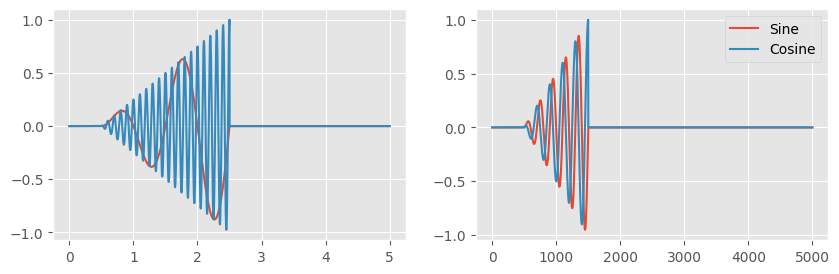

In [4]:
t = np.arange(5000)/1000
sin_wave = IncreasingSine(amp=1, freq=1, duration=2, delay=0.5)
cos_wave = IncreasingCosine(amp=1, freq=10, duration=2, delay=0.5)

fig, ax = plt.subplots( figsize=(10, 3), ncols=2)
ax[0].plot(t, sin_wave(t),label='Sine')
ax[0].plot(t, cos_wave(t),label='Cosine')
sin_wave = IncreasingSine(amp=1, freq=5, duration=1, delay=0.5)
cos_wave = IncreasingCosine(amp=1, freq=5, duration=1, delay=0.5)

ax[1].plot(sin_wave(t),label='Sine')
ax[1].plot(cos_wave(t),label='Cosine')

ax[1].legend()


## Single electrode example


In [5]:
# Time resolution
N.dt = 0.005*ms

axon_diameter = 27*um # um
# axon_nodes = 150 # number of axon nodes
# axon model, by default the central node is at origin of the coordinate system
axon_length = 120
stim_distance = -20
meas_distance = 30

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


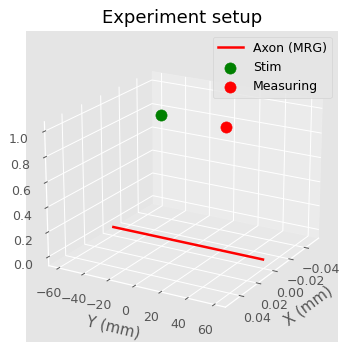

In [ ]:
mrg = create_mrg(diameter=axon_diameter,
                 length=axon_length,
                 v_init=-80, 
                 #axonnodes=axon_nodes, 
                 verbose=True)

# extracellular current source
pointsource = IsotropicPoint(x=0, y = stim_distance * mm, z= 1 * mm, rhoe= 500*ohm*cm)
stim_amp = -1
stim_freq = 5
stim_duration = 2 
stim_delay = 0.25
stim = IncreasingSine(amp=stim_amp, freq=stim_freq,
                      duration=stim_duration,
                      delay=stim_delay)

electrode = pointsource << stim # Assignment

measuring_ps = IsotropicPoint(x=0, y = meas_distance * mm, z= 1 * mm, rhoe= 500*ohm*cm)
v_rec = StateMonitor(mrg.node, "v")

plot_setup_3d(mrg, [pointsource, measuring_ps], ['Stim','Measuring'],
              figsize=(4,4), title='Experiment setup',dpi=90)


In [7]:
# simulation environment
env = SimulationEnvironment(axons=[mrg], extra_stim=[electrode],
                            monitors=[v_rec])
env.run(runtime = 4 * ms,  progressbar=True, early_stopping=False)


3.5 ms: 100%|██████████| 800/800 [00:01<00:00, 535.25it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 1
  dt: 0.005 ms

## Visualizing the nerve conduction overt time and space

In [8]:
mid_point = int(mrg.axonnodes/2)
distance_per_node = axon_length/mrg.axonnodes
displacement_nodes = int(meas_distance/distance_per_node)
print(mid_point, mrg.axonnodes, displacement_nodes)
meas_position = mid_point + displacement_nodes 
print(meas_position)

102 204 51
153


In [9]:
def calculate_delay(stim_time, v_rec, node, threshold=-20, abs_diff=False):
    """
    Calculate the delay of the AP at the measuring point
    """
    result = {
        'delay': np.inf,
        'num_aps': 0,
    }
    
    v = v_rec.v[node, :]
    t = v_rec.t

    as_bool = v > threshold
    pos_arrival = np.where(as_bool)[0]
    
    if len(pos_arrival)==0:
        return result
        
    changes =  np.diff(as_bool.astype(int))    
    pos_arrival = pos_arrival[0]

    result['num_aps'] = np.sum(changes==1)
    
    delay = v_rec.t[pos_arrival] - stim_time
    
    if abs_diff:
        delay = np.abs(delay)
    
    result['delay'] = delay
    
    return result

Text(0.5, 0, 'Time (ms)')

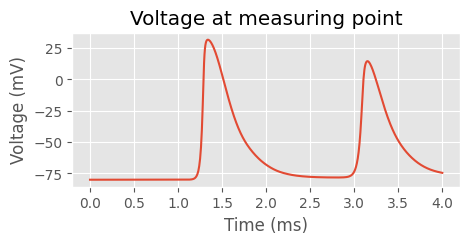

In [10]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(v_rec.t, v_rec.v[meas_position,:])
ax.set_title("Voltage at measuring point")
ax.set_ylabel("Voltage (mV)")
ax.set_xlabel("Time (ms)")

Delay: 1.03 ms
{'delay': 1.0349999999999837, 'num_aps': 2}


<Axes: title={'center': 'AP propagation'}, xlabel='Time (ms)', ylabel='Node Number'>

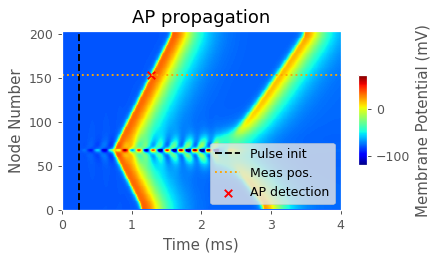

In [11]:
# An example of a failed blocking the AP progression to the right
res = calculate_delay(stim_delay, v_rec, meas_position)
print(f"Delay: {res['delay']:.2f} ms")
print(res)
plot_first_detection(mrg=mrg,
                     v_rec=v_rec,
                     stim_delay=stim_delay,
                     meas_position=meas_position,
                     propagation_delay=res['delay'],
                     figsize=(5,3),
                     dpi=90,
                     title="AP propagation")


## Performing Gaussian Process based Bayesian Optimization

In [13]:
def run_simulation(mrg: MRG, 
                   
                   stim_amp: float = -1.00, #* mA
                   stim_freq: float = 1.0, #kHz
                   stim_pw: float = 0.50, #* ms
                   stim_delay: float = 2.0, #* ms
                   
                   e_pos: float = 20.0, # mm
                   z_pos: float = 1.0, # mm
                   
                   sim_time: float = 5.0, # ms
                   verbose: bool = True) -> dict[str, APMonitor|StateMonitor]:
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp: Amplitude of the stimulus pulse (mA)
    - stim_pw: Pulse width of the simtulus pulse (ms)
    - stim_delay: Delay of the stimulus pulse (ms)
    
    General assumptions:
    - Electrodes are placed along the axon (y axis by default).
    - X placement is centered at 0 mm (origin).
    - Z placement is the same for both electrodes.
    
    - Medium is isotropic with a fixed resistivity of 500 ohm*cm.
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    if verbose:
        print(f"Config: Amp. {stim_amp:.2f} mA Freq. {stim_freq:.2f} KHz,  PW {stim_pw:.2f} ms, Delay {stim_delay:.2f} ms")

    # Create stimuli
    stim = IncreasingSine(amp=stim_amp,
                          freq=stim_freq,
                          duration=stim_duration,
                          delay=stim_delay)

    # Create electrodes at both ends (set spacing of electrode_separation mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=e_pos * mm, z=z_pos * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    
    monitors_dict = dict()
    v_rec = StateMonitor(mrg.node, "v")
    
    monitors_dict['v_rec'] = v_rec
    # Create the simulation environment
    env = SimulationEnvironment(
        axons = [mrg],
        extra_stim = [electrode_stim],
        monitors = [v_rec]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(sim_time * ms, early_stopping=False)
    
    return monitors_dict


def sinusoid_delay_objective(mrg,
                            meas_position,

                            stim_amp = [-1], 
                            stim_pw = [0.5],
                            stim_delay =[2],
                            stim_freq = [1],
                            abs_diff = False,
                            plot_results=False,

                            *args,
                            **kwargs
                            ):
    """
    Objective function to optimize AP blocking
    """  
              
    observations = []
    default_dict = {
        'ap_lines': [],
        'arrival_delay': np.nan
    }
    
    for s_amp, s_pw, s_delay, s_freq in zip(stim_amp, stim_pw, stim_delay, stim_freq):
        # Run the simulation with given parameters
        try:
            monitors_dict = run_simulation(mrg = mrg,
                                           stim_amp = s_amp,
                                           stim_pw = s_pw,
                                           stim_delay = s_delay,
                                           stim_freq = s_freq,
                                           *args,
                                           **kwargs)
            
            v_rec = monitors_dict['v_rec']            
            v_binary = v_rec.v > -0.20 # Assuming some threshold
            
            ap_lines = get_ap_directional(v_binary, 
                                          min_nodes_for_ap_start=1,
                                          y_propagation_threshold=5)
            
            results = calculate_delay(stim_time=s_delay, 
                                      v_rec=v_rec, 
                                      node=meas_position,
                                      abs_diff=abs_diff)
            
            results['ap_lines'] = ap_lines
            
            if plot_results:
                plot_first_detection(mrg=mrg,
                                    v_rec=v_rec,
                                    stim_delay=s_delay,
                                    meas_position=meas_position,
                                    propagation_delay=results['delay'],
                                    figsize=(5,3),
                                    dpi=90,
                                    title="AP propagation")
                plt.show()
            print(results)
            
            observations.append(results)

        except Exception as e:
            print(f"Simulation failed with Amplitude {stim_amp:.2f} mA, Frequency {stim_freq:.2f} Hz,  Pulse Width {stim_pw:.2f} ms, Delay {stim_delay:.2f}")
            observations.append(default_dict)  

    return observations #np.array(observations).reshape(-1, 1)


In [14]:
# Define parameter bounds
# stim_amp = 0.5
# stim_freq = 5 # kHz
# stim_duration = 3 
# stim_delay = 0.5 

lb = [0, 1.0, 0.5]  # Lower bounds for [block_amp, freq, pulse_width, block_delay]
ub = [2, 10.0, 3]  # Upper bounds

STIM_DELAY = 0.5
abs_diff = False
# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, 
                            feature_max=ub,
                            output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 30
qp_minmax = search_space.sample(init_samples).numpy()
qp_orig_scale = scaler.inverse_transform(qp_minmax)
stim_delay_vector = init_samples*[STIM_DELAY]

# Set desired diameter, length and v_init
axon_diameter = 27
axon_length = 120
stim_distance = -20
meas_distance = 30

mrg = create_mrg(diameter=axon_diameter,
                 length=axon_length, 
                 v_init=-80, 
                 verbose=True)

mid_point = int(mrg.axonnodes/2)
distance_per_node = axon_length/mrg.axonnodes
displacement_nodes = int(meas_distance / distance_per_node)
meas_position = mid_point + displacement_nodes 


Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


Config: Amp. 1.87 mA Freq. 4.49 KHz,  PW 0.89 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 174.03it/s]


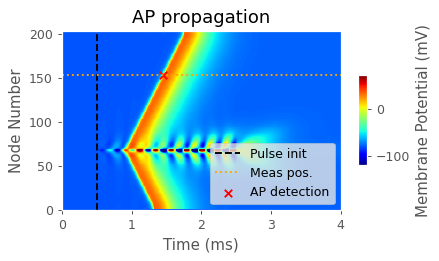

{'delay': 0.9549999999999801, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 177, 'component_end_time': 393, 'upward_line_coords': ((177, 67), (306, 1)), 'downward_line_coords': ((177, 67), (393, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 13, 'component_start_time': 260, 'component_end_time': 278, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 13, 'component_start_time': 305, 'component_end_time': 323, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 13, 'component_start_time': 349, 'component_end_time': 368, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 195.82it/s]


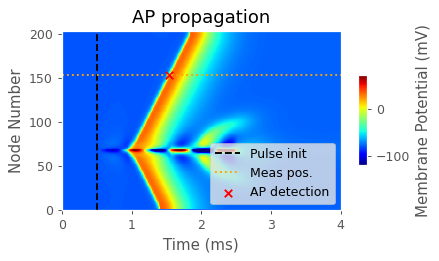

{'delay': 1.0399999999999783, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 190, 'component_end_time': 410, 'upward_line_coords': ((190, 67), (323, 1)), 'downward_line_coords': ((190, 68), (410, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 311, 'component_end_time': 363, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 404, 'component_end_time': 411, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 59, 'max_y_at_start': 59}, {'label': 5, 'total_of_features': 5, 'component_start_time': 404, 'component_end_time': 411, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 76, 'max_y_at_start': 76}, {'label': 4, 'total_of_features': 5

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 179.49it/s]


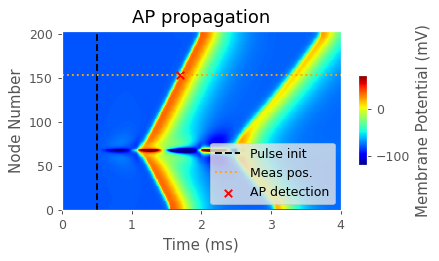

{'delay': 1.189999999999975, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 218, 'component_end_time': 440, 'upward_line_coords': ((218, 67), (354, 1)), 'downward_line_coords': ((218, 68), (440, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 3, 'component_start_time': 398, 'component_end_time': 477, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 3, 'component_start_time': 504, 'component_end_time': 772, 'upward_line_coords': ((504, 59), (637, 1)), 'downward_line_coords': ((504, 76), (772, 202)), 'y_span_at_start': 4, 'min_y_at_start': 59, 'max_y_at_start': 76}]}
Config: Amp. 1.61 mA Freq. 8.85 KHz,  PW 2.42 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 177.01it/s]


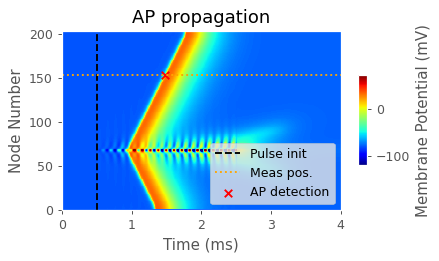

{'delay': 0.9799999999999796, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 21, 'component_start_time': 187, 'component_end_time': 398, 'upward_line_coords': ((187, 67), (311, 1)), 'downward_line_coords': ((187, 68), (398, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 21, 'component_start_time': 249, 'component_end_time': 258, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 21, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 21, 'component_start_time': 295, 'component_end_time': 303, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 202.04it/s]


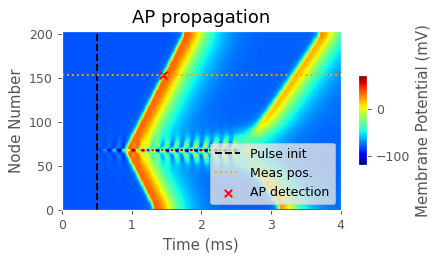

{'delay': 0.9549999999999801, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 17, 'component_start_time': 188, 'component_end_time': 394, 'upward_line_coords': ((188, 69), (307, 1)), 'downward_line_coords': ((188, 69), (394, 202)), 'y_span_at_start': 1, 'min_y_at_start': 69, 'max_y_at_start': 69}, {'label': 5, 'total_of_features': 17, 'component_start_time': 255, 'component_end_time': 265, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 17, 'component_start_time': 284, 'component_end_time': 293, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 17, 'component_start_time': 312, 'component_end_time': 321, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 177.36it/s]


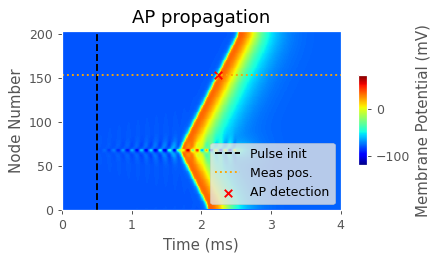

{'delay': 1.7349999999999635, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 344, 'component_end_time': 550, 'upward_line_coords': ((344, 65), (463, 1)), 'downward_line_coords': ((344, 69), (550, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 5, 'component_start_time': 412, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 441, 'component_end_time': 444, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 468, 'component_end_time': 470, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 5

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 195.26it/s]


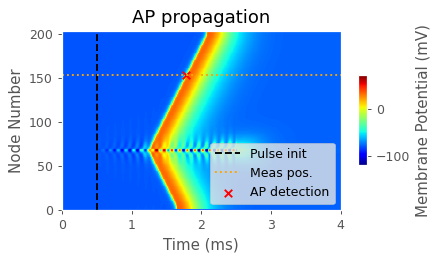

{'delay': 1.284999999999973, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 250, 'component_end_time': 460, 'upward_line_coords': ((250, 67), (373, 1)), 'downward_line_coords': ((250, 68), (460, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 10, 'component_start_time': 312, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 335, 'component_end_time': 341, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 10, 'component_start_time': 357, 'component_end_time': 363, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 9, 'total_of_features'

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 211.79it/s]


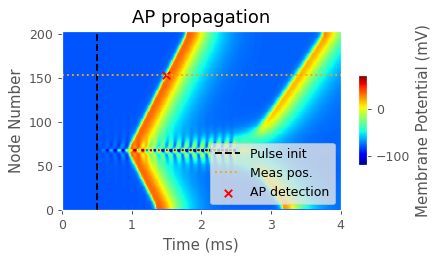

{'delay': 0.9949999999999792, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 20, 'component_start_time': 196, 'component_end_time': 401, 'upward_line_coords': ((196, 64), (314, 1)), 'downward_line_coords': ((196, 70), (401, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 5, 'total_of_features': 20, 'component_start_time': 251, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 20, 'component_start_time': 274, 'component_end_time': 282, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 20, 'component_start_time': 297, 'component_end_time': 305, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 180.65it/s]


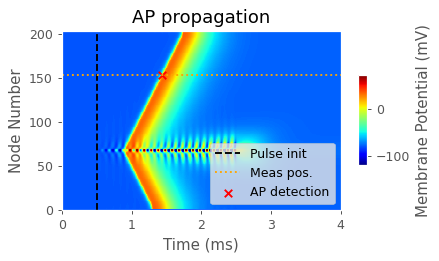

{'delay': 0.9349999999999805, 'num_aps': 1, 'ap_lines': [{'label': 23, 'total_of_features': 30, 'component_start_time': 179, 'component_end_time': 180, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 30, 'component_start_time': 183, 'component_end_time': 389, 'upward_line_coords': ((183, 69), (302, 1)), 'downward_line_coords': ((183, 69), (389, 202)), 'y_span_at_start': 1, 'min_y_at_start': 69, 'max_y_at_start': 69}, {'label': 9, 'total_of_features': 30, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 30, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 60, 'max_y_at_start': 63}, {'label': 29, 'total_of_featur

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 202.06it/s]


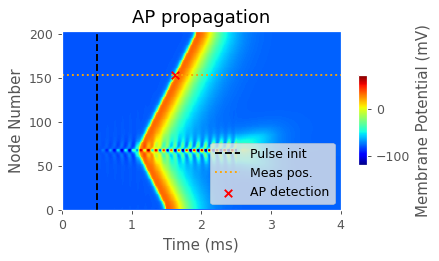

{'delay': 1.1249999999999765, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 222, 'component_end_time': 427, 'upward_line_coords': ((222, 67), (340, 1)), 'downward_line_coords': ((222, 68), (427, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 11, 'component_start_time': 288, 'component_end_time': 296, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 11, 'component_start_time': 311, 'component_end_time': 317, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 11, 'component_start_time': 333, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 192.04it/s]


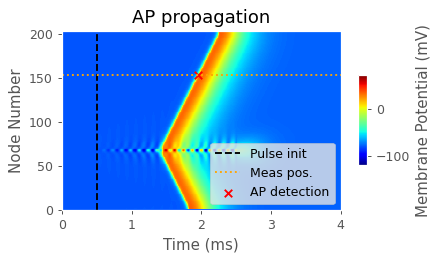

{'delay': 1.4499999999999695, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 289, 'component_end_time': 493, 'upward_line_coords': ((289, 64), (406, 1)), 'downward_line_coords': ((289, 71), (493, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 8, 'component_start_time': 344, 'component_end_time': 353, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 377, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 398, 'component_end_time': 402, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 192.40it/s]


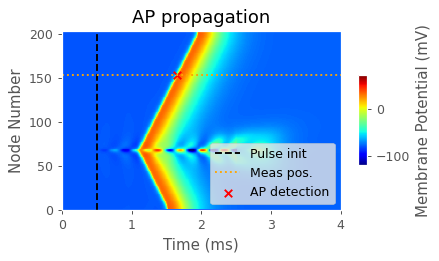

{'delay': 1.149999999999976, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 221, 'component_end_time': 433, 'upward_line_coords': ((221, 67), (346, 1)), 'downward_line_coords': ((221, 68), (433, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 333, 'component_end_time': 347, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 396, 'component_end_time': 415, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 456, 'component_end_time': 479, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.81 mA Freq. 3.12 KHz

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.72it/s]


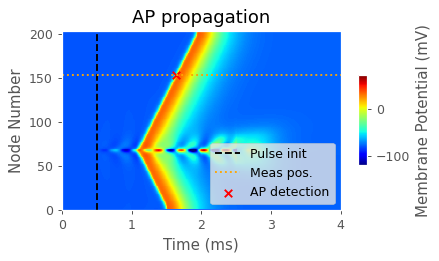

{'delay': 1.1399999999999761, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 216, 'component_end_time': 431, 'upward_line_coords': ((216, 67), (344, 1)), 'downward_line_coords': ((216, 67), (431, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 333, 'component_end_time': 353, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 419, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 459, 'component_end_time': 484, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 1.43 mA Freq. 3.53 KH

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 186.71it/s]


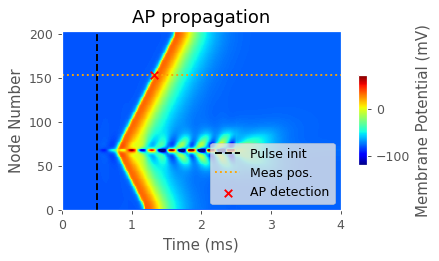

{'delay': 0.8249999999999829, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 161, 'component_end_time': 367, 'upward_line_coords': ((161, 66), (281, 1)), 'downward_line_coords': ((161, 69), (367, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 8, 'component_start_time': 248, 'component_end_time': 268, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 305, 'component_end_time': 326, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 360, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 180.53it/s]


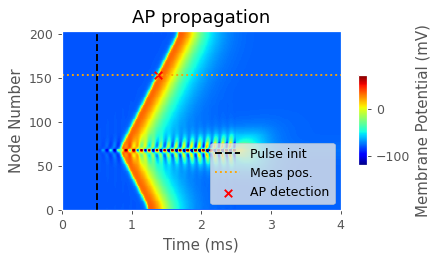

{'delay': 0.8749999999999818, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 27, 'component_start_time': 172, 'component_end_time': 377, 'upward_line_coords': ((172, 65), (290, 1)), 'downward_line_coords': ((172, 70), (377, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 8, 'total_of_features': 27, 'component_start_time': 224, 'component_end_time': 233, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 27, 'component_start_time': 247, 'component_end_time': 255, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 27, 'component_start_time': 269, 'component_end_time': 277, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_featur

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 189.17it/s]


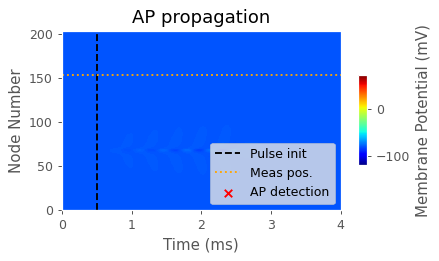

{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 1.66 mA Freq. 8.66 KHz,  PW 2.08 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 189.81it/s]


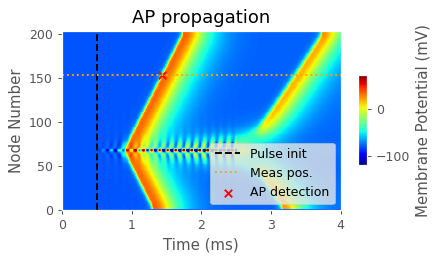

{'delay': 0.9399999999999804, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 26, 'component_start_time': 184, 'component_end_time': 390, 'upward_line_coords': ((184, 67), (303, 1)), 'downward_line_coords': ((184, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 26, 'component_start_time': 229, 'component_end_time': 239, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 9, 'total_of_features': 26, 'component_start_time': 253, 'component_end_time': 261, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 26, 'component_start_time': 276, 'component_end_time': 284, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 11, 'total_of_featur

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 185.75it/s]


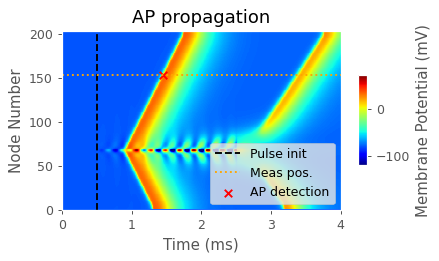

{'delay': 0.9449999999999803, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 182, 'component_end_time': 391, 'upward_line_coords': ((182, 67), (304, 1)), 'downward_line_coords': ((182, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 248, 'component_end_time': 263, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 10, 'component_start_time': 291, 'component_end_time': 304, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 331, 'component_end_time': 346, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 205.41it/s]


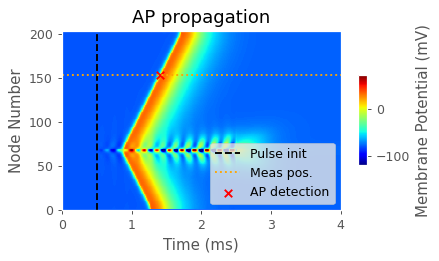

{'delay': 0.9049999999999812, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 178, 'component_end_time': 383, 'upward_line_coords': ((178, 65), (297, 1)), 'downward_line_coords': ((178, 70), (383, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 3, 'total_of_features': 11, 'component_start_time': 228, 'component_end_time': 243, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 11, 'component_start_time': 267, 'component_end_time': 279, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 11, 'component_start_time': 303, 'component_end_time': 315, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.26it/s]


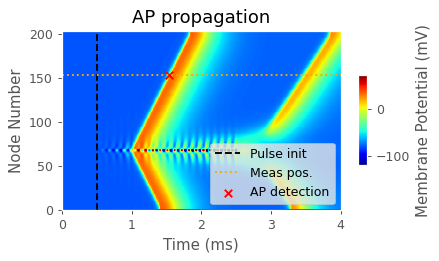

{'delay': 1.0399999999999783, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 19, 'component_start_time': 200, 'component_end_time': 411, 'upward_line_coords': ((200, 67), (323, 1)), 'downward_line_coords': ((200, 68), (411, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 19, 'component_start_time': 257, 'component_end_time': 265, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 19, 'component_start_time': 278, 'component_end_time': 285, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 19, 'component_start_time': 299, 'component_end_time': 306, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 208.29it/s]


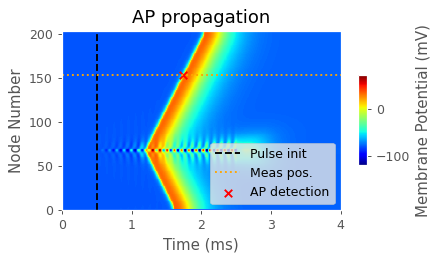

{'delay': 1.239999999999974, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 241, 'component_end_time': 451, 'upward_line_coords': ((241, 67), (364, 1)), 'downward_line_coords': ((241, 68), (451, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 11, 'component_start_time': 298, 'component_end_time': 306, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 11, 'component_start_time': 320, 'component_end_time': 326, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 11, 'component_start_time': 341, 'component_end_time': 346, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_feature

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 221.84it/s]


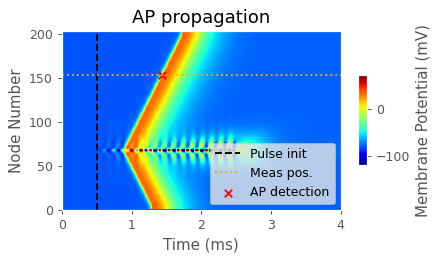

{'delay': 0.9299999999999806, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 20, 'component_start_time': 177, 'component_end_time': 388, 'upward_line_coords': ((177, 67), (301, 1)), 'downward_line_coords': ((177, 68), (388, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 20, 'component_start_time': 249, 'component_end_time': 259, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 20, 'component_start_time': 276, 'component_end_time': 286, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 20, 'component_start_time': 303, 'component_end_time': 313, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 205.77it/s]


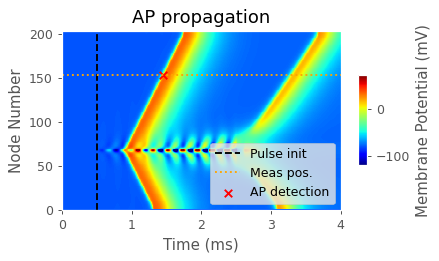

{'delay': 0.9449999999999803, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 14, 'component_start_time': 178, 'component_end_time': 391, 'upward_line_coords': ((178, 67), (304, 1)), 'downward_line_coords': ((178, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 14, 'component_start_time': 253, 'component_end_time': 269, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 14, 'component_start_time': 297, 'component_end_time': 313, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 14, 'component_start_time': 339, 'component_end_time': 356, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 162.83it/s]


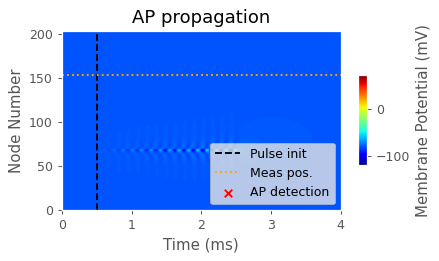

{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 1.93 mA Freq. 7.82 KHz,  PW 2.76 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.26it/s]


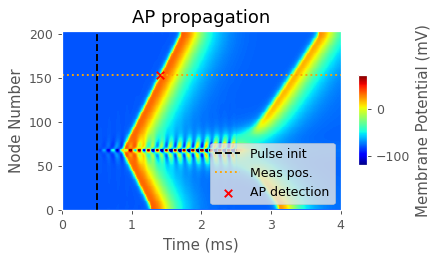

{'delay': 0.9149999999999809, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 27, 'component_start_time': 173, 'component_end_time': 385, 'upward_line_coords': ((173, 67), (298, 1)), 'downward_line_coords': ((173, 67), (385, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 11, 'total_of_features': 27, 'component_start_time': 243, 'component_end_time': 253, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 12, 'total_of_features': 27, 'component_start_time': 269, 'component_end_time': 279, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 13, 'total_of_features': 27, 'component_start_time': 295, 'component_end_time': 305, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 14, 'total_of_feat

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 186.76it/s]


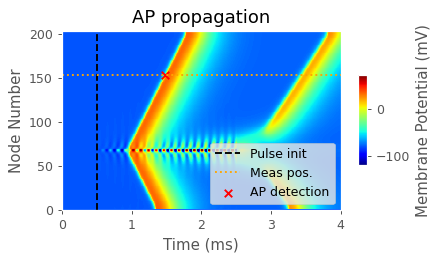

{'delay': 0.9849999999999794, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 21, 'component_start_time': 194, 'component_end_time': 399, 'upward_line_coords': ((194, 64), (312, 1)), 'downward_line_coords': ((194, 71), (399, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 6, 'total_of_features': 21, 'component_start_time': 244, 'component_end_time': 253, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 21, 'component_start_time': 267, 'component_end_time': 274, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 21, 'component_start_time': 289, 'component_end_time': 296, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.35it/s]


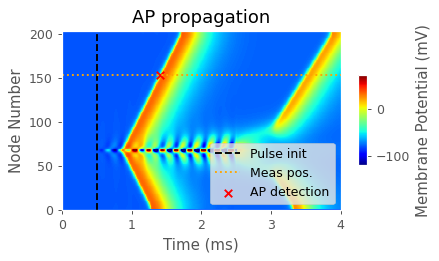

{'delay': 0.9149999999999809, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 19, 'component_start_time': 171, 'component_end_time': 385, 'upward_line_coords': ((171, 67), (298, 1)), 'downward_line_coords': ((171, 68), (385, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 19, 'component_start_time': 241, 'component_end_time': 257, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 19, 'component_start_time': 281, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 10, 'total_of_features': 19, 'component_start_time': 320, 'component_end_time': 336, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 11, 'total_of_featur

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 185.32it/s]


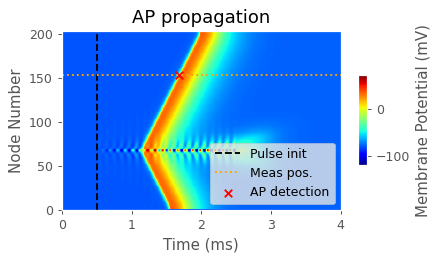

{'delay': 1.1849999999999752, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 234, 'component_end_time': 439, 'upward_line_coords': ((234, 65), (352, 1)), 'downward_line_coords': ((234, 70), (439, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 11, 'component_start_time': 285, 'component_end_time': 294, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 11, 'component_start_time': 308, 'component_end_time': 314, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 11, 'component_start_time': 330, 'component_end_time': 336, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_featur

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 190.18it/s]


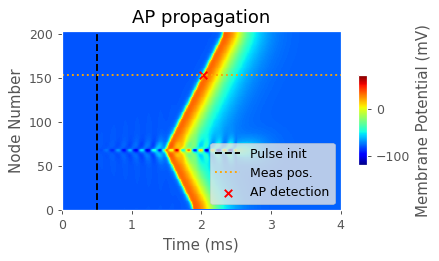

{'delay': 1.519999999999968, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 296, 'component_end_time': 507, 'upward_line_coords': ((296, 67), (420, 1)), 'downward_line_coords': ((296, 67), (507, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 358, 'component_end_time': 369, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 395, 'component_end_time': 401, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 430, 'component_end_time': 436, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 6,

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 177.39it/s]


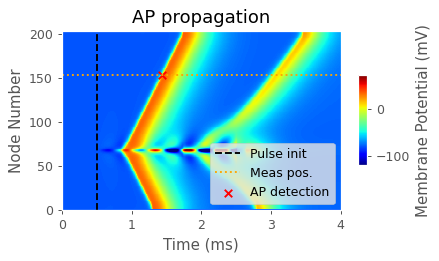

{'delay': 0.9349999999999805, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 173, 'component_end_time': 389, 'upward_line_coords': ((173, 67), (302, 1)), 'downward_line_coords': ((173, 68), (389, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 250, 'component_end_time': 284, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 347, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 439, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 7

In [16]:
# Compute observations of for the initial amount of samples
observations = sinusoid_delay_objective(mrg,
                                       stim_amp=qp_orig_scale[:, 0],
                                       stim_freq=qp_orig_scale[:, 1],
                                       stim_pw=qp_orig_scale[:, 2],
                                       stim_delay=stim_delay_vector,
                                       meas_position = meas_position, 
                                       e_pos=stim_distance,
                                       abs_diff=False,
                                       sim_time=4,
                                       plot_results=True)

## Visualizing initial samples

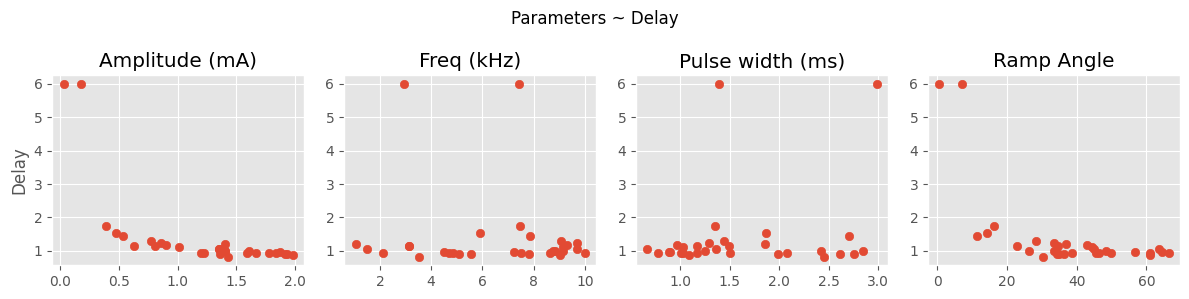

In [22]:
fig, ax = plt.subplots(ncols=4,figsize=(12,3))
ax[0].scatter(qp_orig_scale[:,0], obs_label)
ax[1].scatter(qp_orig_scale[:,1], obs_label)
ax[2].scatter(qp_orig_scale[:,2], obs_label)
ax[3].scatter(np.degrees(np.arctan(qp_orig_scale[:,0]/qp_orig_scale[:,2])), obs_label)
ax[0].set_ylabel("Delay")
ax[0].set_title("Amplitude (mA)")
ax[1].set_title("Freq (kHz)")
ax[2].set_title("Pulse width (ms)")
ax[3].set_title("Ramp Angle")
fig.suptitle("Parameters ~ Delay")
fig.tight_layout()

## Meta-models


Here we will approach the model in three different ways:
- As a learning approach focused on reducing Global Uncertainty by means of PredictiveVariance (eventually could be done with IntegratedVarianceReduction).
- As an online optimization problem focused on finding better minimums. In this case, we will defined a target desired delay and model it as an absolute loss so that negative and positive delays are counted the same. We can use ExpectedImprovement or AugmentedExpectedImprovement (a more exploration driven variation)
- As a Constrained optimization in which we use ExpectedImprovement and ProbabilityofFeasibility with the intention of targeting a certain delay while avoiding triggering 2 APs.

### Variance Reduction
This model focuses in reducing global variance (exploration) using PredictiveVariance

In [23]:
obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
obs_label[obs_label == np.inf] = 6
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))
# We replace np.inf values with a fixed and relatively large value 
#  (outside of the simulation range)

In [24]:

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [25]:
# Build model
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': False,
    'noise_free': True,
    'kernel_variance': None
}

online_model = online_learning.build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = PredictiveVariance()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [26]:
# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = meas_position, 
                                            e_pos = stim_distance,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    obs_label[obs_label == np.inf] = 6    

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.00 mA Freq. 10.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.95it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.29 mA Freq. 1.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 203.04it/s]


{'delay': 1.334999999999972, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 257, 'component_end_time': 469, 'upward_line_coords': ((257, 67), (383, 1)), 'downward_line_coords': ((257, 68), (469, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 439, 'component_end_time': 464, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.00 mA Freq. 1.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 182.55it/s]


{'delay': 1.2199999999999744, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 227, 'component_end_time': 446, 'upward_line_coords': ((227, 67), (360, 1)), 'downward_line_coords': ((227, 68), (446, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 415, 'component_end_time': 493, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 2.00 mA Freq. 1.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 176.83it/s]


{'delay': 1.2149999999999745, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 218, 'component_end_time': 445, 'upward_line_coords': ((218, 67), (359, 1)), 'downward_line_coords': ((218, 67), (445, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 411, 'component_end_time': 499, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 513, 'component_end_time': 644, 'upward_line_coords': ((513, 61), (644, 1)), 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 61, 'max_y_at_start': 63}, {'label': 4, 'total_of_features': 4, 'component_start_time': 513, 'component_end_time': 779, 'upward_line_coords': None, 'downward_line_coords': ((513, 74), (779, 202)), 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start': 74}]

3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 154.08it/s]


{'delay': 1.2099999999999747, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 220, 'component_end_time': 444, 'upward_line_coords': ((220, 67), (359, 1)), 'downward_line_coords': ((220, 68), (444, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 412, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 527, 'component_end_time': 785, 'upward_line_coords': None, 'downward_line_coords': ((527, 75), (785, 202)), 'y_span_at_start': 3, 'min_y_at_start': 73, 'max_y_at_start': 75}, {'label': 2, 'total_of_features': 4, 'component_start_time': 529, 'component_end_time': 656, 'upward_line_coords': ((529, 60), (656, 1)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 185.98it/s]


{'delay': 2.309999999999951, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 451, 'component_end_time': 664, 'upward_line_coords': ((451, 67), (577, 1)), 'downward_line_coords': ((451, 68), (664, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.25 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 180.12it/s]


{'delay': 2.4299999999999486, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 483, 'component_end_time': 688, 'upward_line_coords': ((483, 65), (601, 1)), 'downward_line_coords': ((483, 70), (688, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}]}
Config: Amp. 0.55 mA Freq. 1.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 180.01it/s]


{'delay': 1.2549999999999737, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 238, 'component_end_time': 454, 'upward_line_coords': ((238, 67), (367, 1)), 'downward_line_coords': ((238, 68), (454, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 420, 'component_end_time': 485, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.53 mA Freq. 10.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.28it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 306, 'component_end_time': 511, 'upward_line_coords': ((306, 64), (424, 1)), 'downward_line_coords': ((306, 71), (511, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 9

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 171.65it/s]


{'delay': 1.0699999999999776, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 207, 'component_end_time': 416, 'upward_line_coords': ((207, 67), (329, 1)), 'downward_line_coords': ((207, 67), (416, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 263, 'component_end_time': 277, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 301, 'component_end_time': 312, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 337, 'component_end_time': 348, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 188.63it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.00 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 188.34it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 1.15 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 181.32it/s]


{'delay': 1.094999999999977, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 213, 'component_end_time': 421, 'upward_line_coords': ((213, 67), (334, 1)), 'downward_line_coords': ((213, 67), (421, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features'

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.06it/s]


{'delay': 1.239999999999974, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 233, 'component_end_time': 450, 'upward_line_coords': ((233, 67), (363, 1)), 'downward_line_coords': ((233, 68), (450, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 417, 'component_end_time': 489, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 2.00 mA Freq. 1.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 200.37it/s]


{'delay': 1.2149999999999745, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 218, 'component_end_time': 445, 'upward_line_coords': ((218, 67), (359, 1)), 'downward_line_coords': ((218, 67), (445, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 411, 'component_end_time': 499, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 513, 'component_end_time': 644, 'upward_line_coords': ((513, 61), (644, 1)), 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 61, 'max_y_at_start': 63}, {'label': 4, 'total_of_features': 4, 'component_start_time': 513, 'component_end_time': 779, 'upward_line_coords': None, 'downward_line_coords': ((513, 74), (779, 202)), 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start': 74}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 177.66it/s]


{'delay': 1.2099999999999747, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 221, 'component_end_time': 444, 'upward_line_coords': ((221, 67), (358, 1)), 'downward_line_coords': ((221, 68), (444, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 412, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 539, 'component_end_time': 791, 'upward_line_coords': None, 'downward_line_coords': ((539, 75), (791, 202)), 'y_span_at_start': 2, 'min_y_at_start': 74, 'max_y_at_start': 75}, {'label': 2, 'total_of_features': 4, 'component_start_time': 542, 'component_end_time': 666, 'upward_line_coords': ((542, 60), (666, 1)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 186.85it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.28 mA Freq. 4.38 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 183.34it/s]


{'delay': 1.8899999999999602, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 370, 'component_end_time': 580, 'upward_line_coords': ((370, 67), (493, 1)), 'downward_line_coords': ((370, 67), (580, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 2, 'component_start_time': 452, 'component_end_time': 458, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.41 mA Freq. 1.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 164.59it/s]


{'delay': 1.284999999999973, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 245, 'component_end_time': 459, 'upward_line_coords': ((245, 67), (373, 1)), 'downward_line_coords': ((245, 68), (459, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 424, 'component_end_time': 479, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.66 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 185.37it/s]


{'delay': 1.3999999999999706, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 274, 'component_end_time': 482, 'upward_line_coords': ((274, 67), (395, 1)), 'downward_line_coords': ((274, 68), (482, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 10, 'component_start_time': 332, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 178.40it/s]


{'delay': 0.9749999999999797, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 187, 'component_end_time': 397, 'upward_line_coords': ((187, 67), (310, 1)), 'downward_line_coords': ((187, 67), (397, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 7, 'component_start_time': 259, 'component_end_time': 274, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 305, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 348, 'component_end_time': 364, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 175.38it/s]


{'delay': 1.2149999999999745, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 219, 'component_end_time': 445, 'upward_line_coords': ((219, 67), (359, 1)), 'downward_line_coords': ((219, 68), (445, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 411, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 518, 'component_end_time': 781, 'upward_line_coords': None, 'downward_line_coords': ((518, 74), (781, 202)), 'y_span_at_start': 2, 'min_y_at_start': 73, 'max_y_at_start': 74}, {'label': 2, 'total_of_features': 4, 'component_start_time': 519, 'component_end_time': 649, 'upward_line_coords': ((519, 60), (649, 1)), 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 60, 'max_y_at_start': 62}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 169.21it/s]


{'delay': 1.2249999999999743, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 229, 'component_end_time': 447, 'upward_line_coords': ((229, 67), (361, 1)), 'downward_line_coords': ((229, 68), (447, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 416, 'component_end_time': 492, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 2.00 mA Freq. 5.14 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 190.00it/s]


{'delay': 0.909999999999981, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 19, 'component_start_time': 170, 'component_end_time': 384, 'upward_line_coords': ((170, 67), (297, 1)), 'downward_line_coords': ((170, 68), (384, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 19, 'component_start_time': 239, 'component_end_time': 255, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 9, 'total_of_features': 19, 'component_start_time': 279, 'component_end_time': 294, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 10, 'total_of_features': 19, 'component_start_time': 318, 'component_end_time': 334, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_feature

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 201.82it/s]


{'delay': 1.2999999999999727, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 251, 'component_end_time': 462, 'upward_line_coords': ((251, 67), (375, 1)), 'downward_line_coords': ((251, 67), (462, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 305, 'component_end_time': 318, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 8, 'component_start_time': 339, 'component_end_time': 348, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 8, 'component_start_time': 371, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 203.09it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.41 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 206.22it/s]


{'delay': 1.804999999999962, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 355, 'component_end_time': 563, 'upward_line_coords': ((355, 67), (476, 1)), 'downward_line_coords': ((355, 68), (563, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 6, 'component_start_time': 412, 'component_end_time': 419, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 434, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 455, 'component_end_time': 457, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 6,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 202.75it/s]


{'delay': 0.9849999999999794, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 20, 'component_start_time': 193, 'component_end_time': 399, 'upward_line_coords': ((193, 66), (312, 1)), 'downward_line_coords': ((193, 68), (399, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 20, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 20, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 20, 'component_start_time': 293, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 188.77it/s]


{'delay': 1.2099999999999747, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 221, 'component_end_time': 444, 'upward_line_coords': ((221, 67), (358, 1)), 'downward_line_coords': ((221, 67), (444, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 412, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 584, 'component_end_time': 800, 'upward_line_coords': None, 'downward_line_coords': ((584, 77), (800, 202)), 'y_span_at_start': 3, 'min_y_at_start': 75, 'max_y_at_start': 77}, {'label': 2, 'total_of_features': 4, 'component_start_time': 599, 'component_end_time': 714, 'upward_line_coords': ((599, 59), (714, 1)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 59, 'max_y_at_start': 60}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 175.97it/s]


{'delay': 1.2199999999999744, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 226, 'component_end_time': 446, 'upward_line_coords': ((226, 67), (359, 1)), 'downward_line_coords': ((226, 68), (446, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 414, 'component_end_time': 494, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.26 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 211.03it/s]


{'delay': 1.0399999999999783, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 16, 'component_start_time': 206, 'component_end_time': 411, 'upward_line_coords': ((206, 64), (324, 1)), 'downward_line_coords': ((206, 71), (411, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 3, 'total_of_features': 16, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 16, 'component_start_time': 264, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 16, 'total_of_features': 16, 'component_start_time': 264, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 73, 'max_y_at_start': 74}, {'label': 4, 'total_of_feature

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 179.40it/s]


{'delay': 0.95999999999998, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 179, 'component_end_time': 394, 'upward_line_coords': ((179, 67), (307, 1)), 'downward_line_coords': ((179, 68), (394, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 12, 'component_start_time': 259, 'component_end_time': 276, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 12, 'component_start_time': 305, 'component_end_time': 322, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 12, 'component_start_time': 348, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features':

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 179.19it/s]


{'delay': 0.9399999999999804, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 27, 'component_start_time': 185, 'component_end_time': 390, 'upward_line_coords': ((185, 64), (303, 1)), 'downward_line_coords': ((185, 71), (390, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 8, 'total_of_features': 27, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 27, 'component_start_time': 243, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 62, 'max_y_at_start': 62}, {'label': 27, 'total_of_features': 27, 'component_start_time': 243, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 72, 'max_y_at_start': 73}, {'label': 9, 'total_of_feature

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 168.76it/s]


{'delay': 2.5399999999999463, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 503, 'component_end_time': 710, 'upward_line_coords': ((503, 67), (623, 1)), 'downward_line_coords': ((503, 68), (710, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 1.14 mA Freq. 7.33 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.45it/s]


{'delay': 1.0749999999999775, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 206, 'component_end_time': 417, 'upward_line_coords': ((206, 67), (330, 1)), 'downward_line_coords': ((206, 67), (417, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 12, 'component_start_time': 281, 'component_end_time': 290, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 12, 'component_start_time': 309, 'component_end_time': 317, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 12, 'component_start_time': 336, 'component_end_time': 345, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 202.08it/s]


{'delay': 1.1699999999999755, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 11, 'component_start_time': 228, 'component_end_time': 436, 'upward_line_coords': ((228, 67), (349, 1)), 'downward_line_coords': ((228, 67), (436, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 11, 'component_start_time': 276, 'component_end_time': 290, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 11, 'component_start_time': 311, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 11, 'component_start_time': 343, 'component_end_time': 352, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.04it/s]


{'delay': 1.4049999999999705, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 274, 'component_end_time': 484, 'upward_line_coords': ((274, 67), (397, 1)), 'downward_line_coords': ((274, 68), (484, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 379, 'component_end_time': 384, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 437, 'component_end_time': 448, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 4, 'component_start_time': 492, 'component_end_time': 501, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.50 mA Freq. 6.70 KH

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.99it/s]


{'delay': 0.9749999999999797, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 19, 'component_start_time': 186, 'component_end_time': 397, 'upward_line_coords': ((186, 67), (310, 1)), 'downward_line_coords': ((186, 68), (397, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 19, 'component_start_time': 236, 'component_end_time': 249, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 19, 'component_start_time': 268, 'component_end_time': 278, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 19, 'component_start_time': 298, 'component_end_time': 308, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.97it/s]


{'delay': 1.1099999999999768, 'num_aps': 2, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 209, 'component_end_time': 425, 'upward_line_coords': ((209, 67), (338, 1)), 'downward_line_coords': ((209, 67), (425, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 7, 'component_start_time': 322, 'component_end_time': 342, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 383, 'component_end_time': 405, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 442, 'component_end_time': 466, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 221.80it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.29 mA Freq. 6.93 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.00it/s]


{'delay': 2.0149999999999575, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 402, 'component_end_time': 606, 'upward_line_coords': ((402, 64), (519, 1)), 'downward_line_coords': ((402, 70), (606, 202)), 'y_span_at_start': 3, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 2, 'component_start_time': 465, 'component_end_time': 472, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}


In [27]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
col_names = ['Amplitude (mA)', 'Pulse width (ms)', 'Delay (ms)']
df_min_variance = pd.DataFrame(all_qp_array, columns=col_names)
df_min_variance['sample_type'] = all_sample_types_array
df_min_variance = pd.concat([df_min_variance, df_all_observations],axis=1)
# Map 'ap_count' to labels
#df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

In [28]:
df_min_variance

,Amplitude (mA),Pulse width (ms),Delay (ms),sample_type,delay,num_aps,ap_lines
0,1.867667,4.487557,0.886586,Initial,0.955,1,"[{'label': 1, 'total_of_features': 13, 'compon..."
1,1.353886,1.492867,1.360355,Initial,1.040,1,"[{'label': 1, 'total_of_features': 5, 'compone..."
2,1.399576,1.050273,1.853338,Initial,1.190,2,"[{'label': 1, 'total_of_features': 3, 'compone..."
3,1.607900,8.853241,2.420434,Initial,0.980,1,"[{'label': 1, 'total_of_features': 21, 'compon..."
4,1.370551,7.225010,0.901932,Initial,0.955,2,"[{'label': 1, 'total_of_features': 17, 'compon..."
...,...,...,...,...,...,...,...
66,0.418258,3.398325,3.000000,Optimization,1.405,1,"[{'label': 1, 'total_of_features': 4, 'compone..."
67,1.502809,6.701695,3.000000,Optimization,0.975,2,"[{'label': 1, 'total_of_features': 19, 'compon..."
68,0.948366,3.274208,0.500000,Optimization,1.110,2,"[{'label': 1, 'total_of_features': 7, 'compone..."
69,0.065131,7.748886,3.000000,Optimization,inf,0,[]


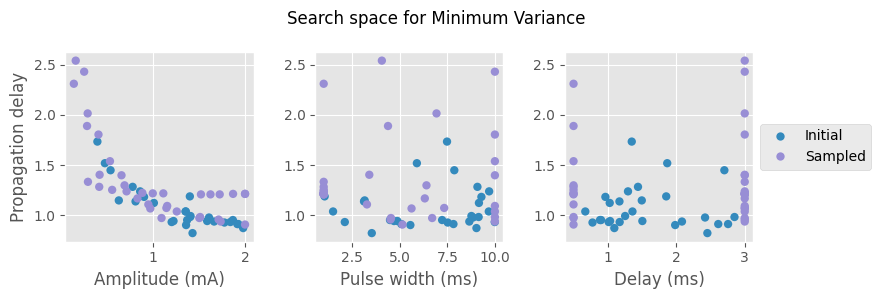

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_variance['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_variance[col], df_min_variance['delay'], c=colors, edgecolors='none')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6)
]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

### Optimizing for a delay
This model focuses in minimizing an objective function using ExpectedImprovement. We modify the objective so that the goal is to find the best parameters to match an exact delay. In this case, the "desired" delay is 1.6 ms, as from the previous model it seems to have a very narrow set of optimal paramters (any other value could be selected here).

In [30]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [31]:
target_delay = 1.6

obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
obs_label[obs_label == np.inf] = 6

obs_label = np.abs(obs_label-target_delay)

init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [32]:
# Build model
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': False,
    'noise_free': True,
    'kernel_variance': None
}

online_model = online_learning.build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = ExpectedImprovement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   )

In [33]:
# Optimization loop as for a next point to query
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = meas_position, 
                                            e_pos = stim_distance,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    obs_label[obs_label == np.inf] = 6    
    # Added to modify the target
    obs_label = np.abs(obs_label-target_delay)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.46 mA Freq. 10.00 KHz,  PW 0.50 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.06it/s]


{'delay': 1.6699999999999648, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 332, 'component_end_time': 536, 'upward_line_coords': ((332, 65), (450, 1)), 'downward_line_coords': ((332, 70), (536, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.95it/s]


{'delay': 1.704999999999964, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 335, 'component_end_time': 544, 'upward_line_coords': ((335, 67), (457, 1)), 'downward_line_coords': ((335, 68), (544, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 7, 'component_start_time': 392, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.89it/s]


{'delay': 1.2749999999999733, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 243, 'component_end_time': 458, 'upward_line_coords': ((243, 67), (371, 1)), 'downward_line_coords': ((243, 68), (458, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 422, 'component_end_time': 481, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.46 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.46it/s]


{'delay': 1.664999999999965, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 331, 'component_end_time': 536, 'upward_line_coords': ((331, 66), (449, 1)), 'downward_line_coords': ((331, 69), (536, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.92it/s]


{'delay': 1.6549999999999652, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 329, 'component_end_time': 533, 'upward_line_coords': ((329, 64), (447, 1)), 'downward_line_coords': ((329, 71), (533, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 235.78it/s]


{'delay': 1.659999999999965, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 330, 'component_end_time': 535, 'upward_line_coords': ((330, 65), (448, 1)), 'downward_line_coords': ((330, 70), (535, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.06it/s]


{'delay': 1.6699999999999648, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 332, 'component_end_time': 537, 'upward_line_coords': ((332, 65), (450, 1)), 'downward_line_coords': ((332, 69), (537, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.65it/s]


{'delay': 1.659999999999965, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 330, 'component_end_time': 535, 'upward_line_coords': ((330, 65), (448, 1)), 'downward_line_coords': ((330, 70), (535, 202)), 'y_span_at_start': 2, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.58it/s]


{'delay': 1.659999999999965, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 330, 'component_end_time': 534, 'upward_line_coords': ((330, 64), (447, 1)), 'downward_line_coords': ((330, 71), (534, 202)), 'y_span_at_start': 8, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 437, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 221.05it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (442, 1)), 'downward_line_coords': ((323, 69), (528, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 234.50it/s]


{'delay': 1.6549999999999652, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 329, 'component_end_time': 533, 'upward_line_coords': ((329, 64), (447, 1)), 'downward_line_coords': ((329, 70), (533, 202)), 'y_span_at_start': 4, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 435, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 7

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 210.64it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (441, 1)), 'downward_line_coords': ((323, 70), (528, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.33it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (442, 1)), 'downward_line_coords': ((323, 69), (528, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.00it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 319, 'component_end_time': 528, 'upward_line_coords': ((319, 67), (441, 1)), 'downward_line_coords': ((319, 67), (528, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 210.32it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (441, 1)), 'downward_line_coords': ((323, 70), (528, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 206.74it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 3, 'total_of_features': 9, 'component_start_time': 320, 'component_end_time': 320, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 9, 'component_start_time': 322, 'component_end_time': 528, 'upward_line_coords': ((322, 66), (441, 1)), 'downward_line_coords': ((322, 66), (528, 202)), 'y_span_at_start': 1, 'min_y_at_start': 66, 'max_y_at_start': 66}, {'label': 2, 'total_of_features': 9, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 9

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.74it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (442, 1)), 'downward_line_coords': ((323, 69), (528, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.94it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (441, 1)), 'downward_line_coords': ((323, 70), (528, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.60it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (442, 1)), 'downward_line_coords': ((323, 69), (528, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.23it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 319, 'component_end_time': 528, 'upward_line_coords': ((319, 67), (441, 1)), 'downward_line_coords': ((319, 67), (528, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 220.31it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 323, 'component_end_time': 528, 'upward_line_coords': ((323, 65), (441, 1)), 'downward_line_coords': ((323, 70), (528, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.68it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 3, 'total_of_features': 9, 'component_start_time': 320, 'component_end_time': 321, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 9, 'component_start_time': 322, 'component_end_time': 528, 'upward_line_coords': ((322, 66), (441, 1)), 'downward_line_coords': ((322, 69), (528, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 9, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 9

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.47it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 325, 'component_end_time': 530, 'upward_line_coords': ((325, 64), (443, 1)), 'downward_line_coords': ((325, 70), (530, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.12it/s]


{'delay': 1.6299999999999657, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 322, 'component_end_time': 528, 'upward_line_coords': ((322, 66), (441, 1)), 'downward_line_coords': ((322, 66), (528, 202)), 'y_span_at_start': 1, 'min_y_at_start': 66, 'max_y_at_start': 66}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 393, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.92it/s]


{'delay': 1.5999999999999663, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 523, 'upward_line_coords': ((314, 67), (436, 1)), 'downward_line_coords': ((314, 67), (523, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.88it/s]


{'delay': 1.5799999999999668, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 519, 'upward_line_coords': ((313, 66), (432, 1)), 'downward_line_coords': ((313, 69), (519, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.61it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 519, 'upward_line_coords': ((313, 67), (432, 1)), 'downward_line_coords': ((313, 68), (519, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.42it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 519, 'upward_line_coords': ((313, 66), (432, 1)), 'downward_line_coords': ((313, 68), (519, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.96it/s]


{'delay': 1.5799999999999668, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 519, 'upward_line_coords': ((313, 66), (432, 1)), 'downward_line_coords': ((313, 69), (519, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.29it/s]


{'delay': 1.5899999999999666, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 520, 'upward_line_coords': ((313, 67), (433, 1)), 'downward_line_coords': ((313, 68), (520, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.95it/s]


{'delay': 1.5799999999999668, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 519, 'upward_line_coords': ((313, 66), (432, 1)), 'downward_line_coords': ((313, 68), (519, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.05it/s]


{'delay': 1.5899999999999666, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 521, 'upward_line_coords': ((314, 67), (434, 1)), 'downward_line_coords': ((314, 68), (521, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.45it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 520, 'upward_line_coords': ((313, 67), (433, 1)), 'downward_line_coords': ((313, 68), (520, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.42it/s]


{'delay': 1.5899999999999666, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 521, 'upward_line_coords': ((314, 66), (434, 1)), 'downward_line_coords': ((314, 68), (521, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.47it/s]


{'delay': 1.5849999999999667, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 313, 'component_end_time': 520, 'upward_line_coords': ((313, 67), (433, 1)), 'downward_line_coords': ((313, 68), (520, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.78it/s]


{'delay': 1.5949999999999664, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 314, 'component_end_time': 522, 'upward_line_coords': ((314, 67), (435, 1)), 'downward_line_coords': ((314, 68), (522, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.62it/s]


{'delay': 1.564999999999967, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 311, 'component_end_time': 515, 'upward_line_coords': ((311, 64), (428, 1)), 'downward_line_coords': ((311, 71), (515, 202)), 'y_span_at_start': 8, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 200.81it/s]


{'delay': 1.619999999999966, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 317, 'component_end_time': 526, 'upward_line_coords': ((317, 67), (439, 1)), 'downward_line_coords': ((317, 68), (526, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8,

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 186.41it/s]


{'delay': 1.569999999999967, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 312, 'component_end_time': 516, 'upward_line_coords': ((312, 64), (429, 1)), 'downward_line_coords': ((312, 71), (516, 202)), 'y_span_at_start': 8, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 8, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8,

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.13it/s]


{'delay': 1.614999999999966, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 316, 'component_end_time': 525, 'upward_line_coords': ((316, 67), (438, 1)), 'downward_line_coords': ((316, 68), (525, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8,

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 211.28it/s]


{'delay': 1.614999999999966, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 316, 'component_end_time': 525, 'upward_line_coords': ((316, 67), (438, 1)), 'downward_line_coords': ((316, 68), (525, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 372, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 415, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8,

In [34]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
col_names = ['Amplitude (mA)', 'Pulse width (ms)', 'Delay (ms)']
df_min_target = pd.DataFrame(all_qp_array, columns=col_names)
df_min_target['sample_type'] = all_sample_types_array
df_min_target = pd.concat([df_min_target, df_all_observations],axis=1)
df_min_target['Loss (MAE)'] = np.abs(df_min_target['delay'] - target_delay)

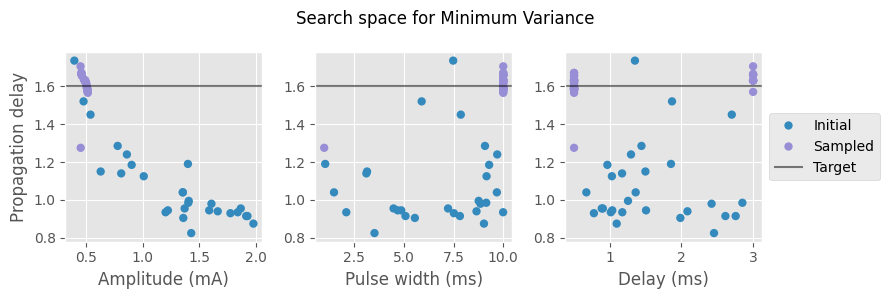

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_target['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_target[col], df_min_target['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

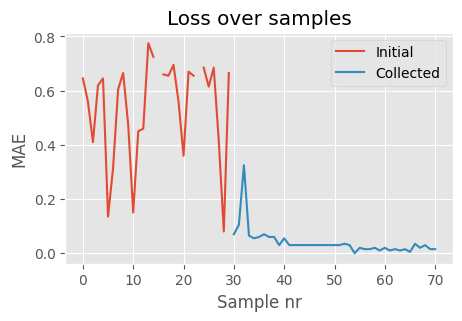

In [36]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_min_target.loc[df_min_target['sample_type']=='Initial']
sub_df_1 = df_min_target.loc[~(df_min_target['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['Loss (MAE)'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_min_target)), sub_df_1['Loss (MAE)'], label='Collected')
ax.set_title("Loss over samples")
ax.set_xlabel("Sample nr")
ax.set_ylabel("MAE")
ax.legend()


Text(0.5, 0.98, 'Distribution of APs')

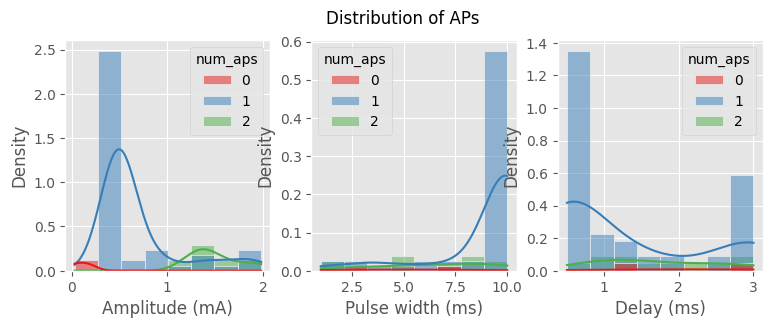

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
for e, col in enumerate(col_names):
    sns.histplot(data=df_min_target, x=col, hue='num_aps',
                 kde=True,
                 #element='step',
                 stat='density',
                 common_norm=True,
                 palette='Set1',
                 ax=ax[e])

    ax[e].set_xlabel(col)
fig.suptitle("Distribution of APs")

## Optimization with constraints

Assume that, hypothetically, we would like to guarantee that only one AP is activated. Say that experiments with no APs are not informative, and that with 2 APs can damage the nerve. This can be approached in multiple ways, here we opt for Feasibility region and focus on optimizing a threshold (as in the last example) while preventing triggering 0, 2 or more than 2 APs.
We extend the first scenario: we want to minimize global uncertainty (Notice that we could also reproduce scenario 2)


In [45]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [46]:
obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
obs_label[obs_label==np.inf] = 6

constraint = np.array([obs['num_aps'] for obs in observations])==1

constraint = constraint.astype(int).reshape(-1,1)


init_dataset_objective = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(obs_label, tf.float64))

init_dataset_constraint = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(constraint, tf.float64))

init_dataset = {
    "OBJECTIVE" : init_dataset_objective,
    "CONSTRAINT" : init_dataset_constraint
}



In [47]:
# Build model
class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset='CONSTRAINT'):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean

        return acquisition
    
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': False,
    'noise_free': True,
    'kernel_variance': None
}

objective_model = online_learning.build_model(init_dataset['OBJECTIVE'], search_space, model_config)

# Classification is True for the Contrained model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': False,
    'noise_free': True,
    'kernel_variance': None
}
constraint_model = online_learning.build_model(init_dataset["CONSTRAINT"], search_space, model_config)

online_models = {"OBJECTIVE": objective_model,
                 "CONSTRAINT": constraint_model
                 }


    
# Set up acquisition function and rule
acq0 = PredictiveVariance()
acq1 = ExpectedFeasibility(threshold=0.5, delta=1)
acq1 = ProbabilityOfValidity()

combined_acquisition = Product(acq0.using("OBJECTIVE"), acq1.using("CONSTRAINT"))
rule = EfficientGlobalOptimization(acq1, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_models,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [48]:
# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = meas_position, 
                                            e_pos = stim_distance,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    obs_label[obs_label == np.inf] = 6    
    
    constraint = np.array([obs['num_aps'] for obs in observations_new])==1
    constraint = constraint.astype(int).reshape(-1,1)


    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = {"OBJECTIVE":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64)),
                     "CONSTRAINT":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(constraint, tf.float64))
    }
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Config: Amp. 0.10 mA Freq. 8.62 KHz,  PW 1.31 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 187.01it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.11 mA Freq. 1.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 193.33it/s]


{'delay': 2.3499999999999504, 'num_aps': 1, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 461, 'component_end_time': 673, 'upward_line_coords': ((461, 67), (586, 1)), 'downward_line_coords': ((461, 68), (673, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.00 mA Freq. 6.66 KHz,  PW 2.62 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.28it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.15 mA Freq. 9.36 KHz,  PW 1.02 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 193.94it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.00 mA Freq. 2.50 KHz,  PW 2.99 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 207.31it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.48 KHz,  PW 2.76 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 205.79it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.15 mA Freq. 9.08 KHz,  PW 1.21 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 208.71it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.78 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.93it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 3.98 KHz,  PW 2.82 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.95it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.44 KHz,  PW 1.15 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.55it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.50 KHz,  PW 2.84 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 213.00it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.25 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.50it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.88 KHz,  PW 1.16 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 212.90it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.27 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 179.66it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.94it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.80 KHz,  PW 1.16 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.02it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.28 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.66it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 186.04it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.81 KHz,  PW 1.16 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.28it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 202.25it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.54it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.81 KHz,  PW 1.16 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.14it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 204.89it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.01 mA Freq. 4.29 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 199.03it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}
Config: Amp. 0.16 mA Freq. 8.81 KHz,  PW 1.16 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 212.06it/s]


{'delay': inf, 'num_aps': 0, 'ap_lines': []}


2025-05-14 15:51:01.457388: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


InvalidArgumentError: {{function_node __wrapped__CheckNumerics_device_/job:localhost/replica:0/task:0/device:CPU:0}} gpflow.Parameter: the value to be assigned is incompatible with this parameter's transform (the corresponding unconstrained value has NaN or Inf) and hence cannot be assigned. : Tensor had NaN values [Op:CheckNumerics] name: 

In [50]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
col_names = ['Amplitude (mA)', 'Pulse width (ms)', 'Delay (ms)']
df_with_constraints = pd.DataFrame(all_qp_array, columns=col_names)
df_with_constraints['sample_type'] = all_sample_types_array
df_with_constraints = pd.concat([df_with_constraints, df_all_observations],axis=1)


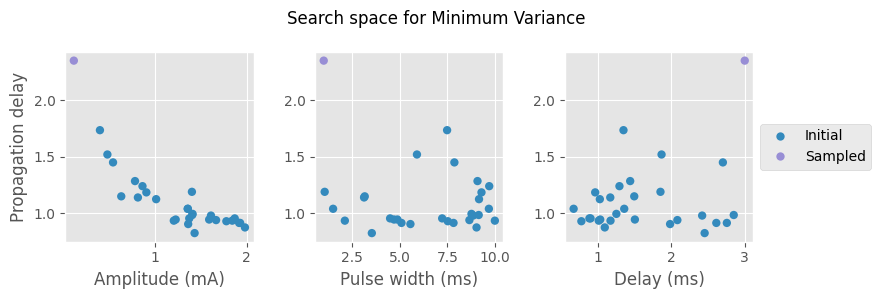

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_with_constraints['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_with_constraints[col], df_with_constraints['delay'], c=colors, edgecolors='none')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6)
]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

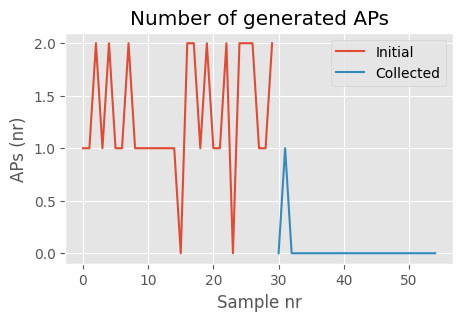

In [53]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_with_constraints.loc[df_with_constraints['sample_type']=='Initial']
sub_df_1 = df_with_constraints.loc[~(df_with_constraints['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['num_aps'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_with_constraints)), sub_df_1['num_aps'], label='Collected')
ax.set_title("Number of generated APs")
ax.set_xlabel("Sample nr")
ax.set_ylabel("APs (nr)")
ax.legend()
